In [5]:
#This is detail decoding of Andrez Karpathy lecture on BackPropagation with my comments/explaination on every step.

import torch # for converting the data to tensor and to leverage PyTorch's capabilities for numerical operations 
import torch.nn.functional as F # and compatibility of torch tensors NN models
import matplotlib.pyplot as plt # for making figures
%matplotlib inline 
# it will auto display the output of matplotlib without writing plt.show() function

In [6]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words)) # Printing the number of characters in longest word
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))# join/combine the words in a set , so it will become like a mix of characters
stoi = {s:i+1 for i,s in enumerate(chars)}# for i,s in enumerate/iterate char, s(char) is assigned to index i plus 1 bcoz index 0 is char period(.)
stoi['.'] = 0 # index 0 is char period(.)
itos = {i:s for s,i in stoi.items()} # once we assign indexes to chars, we can now reverse the key value pair, so that index becomes key and char becomes value
vocab_size = len(itos) # how many key value pair created
print(itos)
print(vocab_size)# it gave output 27 meaning it has all the chars of alphabet (26) plus 1 period

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


def build_dataset(words):  #this function takes words as input
  X, Y = [], [] # here we created 2 empty list X and Y, X we use for our input data and Y will guess the output( in form of index)
  
  for w in words:
    context = [0] * block_size # creating a list named context with size of block size and each element value as 0 ( [0,0,0] )
    for ch in w + '.': # for char in words in names.txt adn plus period char
      ix = stoi[ch] # Using stoi function it will iterate the value/index of each char(1 at a time) and store it in variable
      X.append(context)# here the empty list of X has now become [0,0,0]
      Y.append(ix)# here the empty list of Y has now become the value of variable ix ( Example char d is assigned the value 5
                  # so now in the Y list it will become [5], instead of empty list )
      context = context[1:] + [ix] # now as we maintaining the block size of 3 if we adding new data , we let go the index 0 data
                                 # so now context is [0,0,5], it goes like as follows
                                #X = [0,0,0], Y= [5]
                                #X = [0,0,5], Y= [9]
                                #X = [0,5,9], Y= [21] and so on
  X = torch.tensor(X)#converting the data to tensor is to leverage PyTorch's capabilities for numerical operations
  Y = torch.tensor(Y)#and compatibility with neural network models
  print(X.shape, Y.shape) #will print let say for Xtr,Ytr as torch.Size([182661, 3]) torch.Size([182661])
                                        # meaning its 2 dimensional tensor with 182661 rows and 3 columns/blocksize
  return X, Y

Xtr,  Ytr  = build_dataset(words[:n1])     # 80% 
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
# ok biolerplate done, now we get to the action:

In [11]:
# utility function we will use later when comparing manual gradients to PyTorch gradients, will have more understanding later
def cmp(s, dt, t): # contains 3 parameters
  ex = torch.all(dt == t.grad).item() # dt is a pytorch tensor getting compared with t ,a tensor that change with gradient adjustment
                                      # .item() converts tensor output to python output , in this case boolean output
  app = torch.allclose(dt, t.grad) # checks if the both tensors are approx. equal, giving it some numerical tolernce result in boolean
  maxdiff = (dt - t.grad).abs().max().item() # calculated the absolute diff between 2 tensors
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')
    # results will be printed in string f
    # it will printed as counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
    # s in this case is counts_sum_inv , 15s meeans char can be upto 15 in len, 5s means 5 in len(false has 5 char)
    # {s:15s} means string s with max char 15 

In [12]:
n_embd = 10 # the dimensionality of the character embedding vectors,embedding vectors are numerical representations of characters
n_hidden = 64 # the number of neurons in the hidden layer of the MLP,hidden layer is an intermediate layer between the input and output layers

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)#vocab_size already declared in begining
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
                                                                #this part commonly used to initialize weights in neural networks
                                               #It is designed to provide a reasonable range for the weights, promoting stable training.
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN(batchNormalisation)
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0 #The shape (1, n_hidden) indicates that it's a row vector with n_hidden elements.
                                             #+ 1.0: This part adds 1.0 to each element of the tensor,it helps set an initial value for the bias that is not too close to zero
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total(The nelement() is predefined method is useful when you need to know the total size of a tensor)
                                            #Parameters are the learnable components of a model, such as weights and biases
for p in parameters:
  p.requires_grad = True # attribute of a PyTorch tensor that indicates whether the tensor should track operations for gradient computation

4137


In [13]:
batch_size = 32 #created minibatch, representing the number of examples in each minibatch(32)
                #Minibatches are subsets of the larger dataset that are used for training a machine learning model. 
                #A smaller batch size is often used to perform gradient descent in a more computationally efficient way.
n = batch_size # a shorter variable n for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) #generator=g argument specifies the random number generator (g in this case)
 #generates a random tensor ix containing batch_size indices. The indices are sampled uniformly at random from the range [0, Xtr.shape[0])                
Xb, Yb = Xtr[ix], Ytr[ix] # The minibatch Xb consists of input examples, and Yb consists of corresponding target values

In [14]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors where each row represents the embedding vector for a unique character of mini batch
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors to make then suitable to form linear transformation,and putting those vectors/tensors into new dimension called embcat
                                    # -1 means letting pytorch decide whatever size require to reshape vectors correctly
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation and performing linear transformation on the concatenated embedding vectors
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)#bnmeani, is a tensor containing the mean value for each element along the first dimension (across the minibatch) 
# keepdim ="true" means it will retain back same size/dimensions after sum, it is required cozof limitation of torch to collapse the dimension during summing 
bndiff = hprebn - bnmeani #differences between each pre-activation value and its mean across the minibatch
bndiff2 = bndiff**2 # squaring up the difference to make it more noticable/obvious
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) which adjusts the variance calculation for unbiased estimation.
bnvar_inv = (bnvar + 1e-5)**-0.5 # Adding the small constant 1e-5 to avoid division by zero and to ensure numerical stability
#bnvar_inv, is a tensor containing the reciprocal of the square root of the adjusted variance
bnraw = bndiff * bnvar_inv #bnraw, is a tensor containing the batch-normalized pre-activation values
hpreact = bngain * bnraw + bnbias #batch-normalized pre-activation values with learned scaling and shifting parameters

# Non-linearity
h = torch.tanh(hpreact) # hidden layer,  tanh function squashes its input values to the range [-1, 1]
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values #logit_maxes contains the maximum values along each row of the logits(they are raw output layer without any function like tanh)
norm_logits = logits - logit_maxes # subtract max for numerical stability,this subtracts the maximum values from each element of the tensor logits
counts = norm_logits.exp() #math.exp(x) exponentiates the number 2. The result is e**2 , which is approximately 7.389 as e always =2.71828
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact,so reciprocal of counts_sum,for use in normalization
probs = counts * counts_sum_inv # will give normalized probabilities by dividing each element by the sum of counts
logprobs = probs.log() # will give,this computes the element-wise natural logarithm of the probabilities/ log probabilities
loss = -logprobs[range(n), Yb].mean() # This extracts the log probabilities corresponding to the true labels Yb using fancy indexing. 
#The negative sign and .mean() calculate the average cross-entropy loss over the minibatch
#This Cross-entropy loss measures how well the predicted probabilities match the true distribution. A lower cross-entropy loss indicates a better match.
# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward() #it triggers the backward pass and compute the gradients of the loss with respect to each parameter in the model
loss #printing loss below as tensor
#Note- without functions like tanh , sigmoid, model will only provide linear transformation/straight line.

tensor(3.4922, grad_fn=<NegBackward0>)

In [15]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one
#This type of manual backpropagation is useful for understanding the details of how gradients flow through the network 
#during training. However, it's error-prone and usually unnecessary in practice due to the availability of 
#automatic differentiation in deep learning frameworks like PyTorch


dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]
#cmp('...', ..., ...):A comparison function that prints and compares the gradients for various variables during debugging.    

cmp('logprobs', dlogprobs, logprobs) #Calculates the gradient of the log probabilities with respect to the loss.
cmp('probs', dprobs, probs) #Uses the chain rule to compute the gradient of the probabilities with respect to the loss.
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)#dcounts_sum_inv, dcounts, dcounts_sum:
                                                         #Gradients related to the counts and their sum
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)#dnorm_logits, dlogits, dlogit_maxes:
                                             #Gradients related to normalization of logits.
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h) #dh:Gradient with respect to the hidden layer.
cmp('W2', dW2, W2)#dW2, db2:Gradients with respect to the parameters of the second linear layer
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)#dhpreact, dbngain, dbnraw, dbnbias, dbndiff, ...:Gradients with respect to batch normalization parameters and intermediate variables.
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)#dembcat, dW1, db1, demb, dC:Gradients related to the embedding/embedding layer
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [16]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out
# cross-entropy is commonly used as a loss function to measure the dissimilarity between the predicted probability distribution 
#and the true distribution (ground truth).

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.492246389389038 diff: 0.0


In [17]:
# backward pass

dlogits = F.softmax(logits, 1)# Applies the softmax function to the logits along dimension 1, transforming them into probabilities.
#The resulting dlogits tensor now contains the softmax probabilities
dlogits[range(n), Yb] -= 1#Calculates the gradient of the cross-entropy loss with respect to the logits. 
#It subtracts 1 from the element of each row that corresponds to the true class YB
dlogits /= n #Normalizes the gradient by dividing it by the number of samples in the batch (n) to compute the average gradient across the batch

cmp('logits', dlogits, logits) # Compares the computed gradient (dlogits) with the gradients obtained through automatic differentiation during the forward pass (logits)

logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


In [18]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [19]:
F.softmax(logits, 1)[0] # 1 here is dimension

tensor([0.0372, 0.0175, 0.0239, 0.0226, 0.0478, 0.0585, 0.0842, 0.0208, 0.0363,
        0.0367, 0.0294, 0.0318, 0.0439, 0.0548, 0.0571, 0.0649, 0.0578, 0.0192,
        0.0270, 0.0262, 0.0435, 0.0120, 0.0211, 0.0284, 0.0331, 0.0272, 0.0372],
       grad_fn=<SelectBackward0>)

In [20]:
dlogits[0] * n #n is batch size (32)

tensor([ 0.0372,  0.0175,  0.0239,  0.0226,  0.0478,  0.0585,  0.0842,  0.0208,
         0.0363,  0.0367,  0.0294,  0.0318,  0.0439,  0.0548,  0.0571,  0.0649,
         0.0578,  0.0192, -0.9730,  0.0262,  0.0435,  0.0120,  0.0211,  0.0284,
         0.0331,  0.0272,  0.0372], grad_fn=<MulBackward0>)

In [21]:
dlogits[0].sum() # sum of dlogits /= n

tensor(-1.8626e-09, grad_fn=<SumBackward0>)

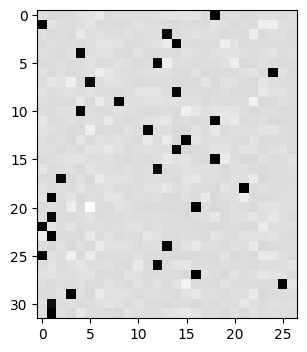

In [22]:
plt.figure(figsize=(4, 4))#figure with dimensions 4 inches by 4 inches
plt.imshow(dlogits.detach(), cmap='gray')# Detaching is necessary when working with matplotlib to avoid potential memory leaks

In [23]:
#backprop through batchnorm but all in one go
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [24]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [25]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape
# 32 , the batch size
#64, the number of neurons in the hidden layer of the MLP

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [29]:
# putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []


with torch.no_grad(): #this decorator disables gradient tracking

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    # If i is less than 100,000, the learning rate is set to 0.1; otherwise, it is set to 0.01. 
    #This is a form of step-wise learning rate decay, where the learning rate decreases after a certain number of iterations.
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable
# This line updates each parameter using its gradient and the current learning rate.
    # track stats
    if i % 10000 == 0: # print everytime iteration/10000 is leaving 0 remainder
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') # will print something like 10000/ 200000: 2.3261
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
#meaning you can comment out these 2 lines
#    if i % 10000 == 0: # print everytime iteration/10000 is leaving 0 remainder
#      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') # will print something like 10000/ 200000: 2.3261

  #     break

12297
      0/ 200000: 3.6226
  10000/ 200000: 2.4935
  20000/ 200000: 2.4056
  30000/ 200000: 2.0886
  40000/ 200000: 1.9836
  50000/ 200000: 2.4180
  60000/ 200000: 2.2720
  70000/ 200000: 2.1422
  80000/ 200000: 1.9688
  90000/ 200000: 1.9700
 100000/ 200000: 2.4428
 110000/ 200000: 2.1775
 120000/ 200000: 2.1829
 130000/ 200000: 2.4737
 140000/ 200000: 2.1939
 150000/ 200000: 2.3375
 160000/ 200000: 2.0872
 170000/ 200000: 1.9991
 180000/ 200000: 2.3914
 190000/ 200000: 1.8835


In [27]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [30]:
# calibrate the batch norm at the end of training  to improve the training stability and speed by normalizing the input to a layer. 
#During training, BatchNorm normalizes the input of a layer by subtracting the mean and dividing by the standard deviation computed over the current mini-batch

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 #hpreact represents the pre-activation values in a neural network
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [31]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1 #hpreact represents the pre-activation values in a neural network
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0722830295562744
val 2.1143195629119873


In [32]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
mad.
ryla.
remmadiendra.
gradelynneliah.
milopi.
eden.
sana.
arleigh.
malaia.
noshubergihimier.
kindreelynn.
noelian.
breyce.
ryyah.
fael.
yuma.
myston.
